In [ ]:
path = r"C:\Users\felip\OneDrive - Universidad Técnica Federico Santa María\Documentos\UV\EEG_ERP_Analysis"


In [ ]:
import pandas as pd

# Leer las líneas del archivo
with open(rf"{path}\Data\PWI_sLoreta_1000_txt\S1_HM_20032024_PWI_Baseline Correction_Con-sLorRoi.txt", "r") as file:
    lines = file.readlines()


# Procesar cada línea, eliminando espacios adicionales y dividiendo por espacios
data = [list(map(float, line.split())) for line in lines if line.strip()]  # Evita líneas vacías

# Convertir a un DataFrame
df = pd.DataFrame(data)

# Mostrar las primeras filas
print(df.head())


In [ ]:
import os
import pandas as pd
import re

# Ruta de la carpeta donde se encuentran los archivos
base_dir = r"C:\Users\felip\OneDrive - Universidad Técnica Federico Santa María\Documentos\UV\EEG_ERP_Analysis\Data\PWI_sLoreta_1000_txt"

# Diccionario para almacenar los identificadores por sujeto
identificadores = {}

# Paso 1: Obtener todos los identificadores únicos
pattern = re.compile(r"S(\d+)_(\w+_\d{8})_PWI")
for file_name in os.listdir(base_dir):
    match = pattern.match(file_name)
    if match:
        sujeto = f"Sujeto_{match.group(1)}"
        identificador = match.group(2)
        if sujeto not in identificadores:
            identificadores[sujeto] = identificador

print("Identificadores extraídos:")
for sujeto, identificador in identificadores.items():
    print(f"  {sujeto}: {identificador}")

# Diccionario para almacenar los datos por condición
Datos = {"con": {}, "rel": {}, "unr": {}}

# Sufijos de archivo por condición
condiciones = {
    "con": "Baseline Correction_Con-sLorRoi.txt",
    "rel": "Baseline Correction_Rel-sLorRoi.txt",
    "unr": "Baseline Correction_Unr-sLorRoi.txt"
}

# Paso 2: Usar los identificadores para construir los nombres de archivo y cargar los datos
for sujeto, identificador in identificadores.items():
    for condicion, sufijo in condiciones.items():
        # Genera el nombre y la ruta completa del archivo
        file_name = f"{sujeto.replace('Sujeto_', 'S')}_{identificador}_PWI_{sufijo}"
        file_path = os.path.join(base_dir, file_name)

        try:
            # Verifica si el archivo existe
            if os.path.exists(file_path):
                # Leer el archivo línea por línea, eliminando espacios adicionales
                with open(file_path, "r") as file:
                    lines = file.readlines()
                
                # Procesar las líneas en forma de DataFrame
                data = [list(map(float, line.split())) for line in lines if line.strip()]
                df = pd.DataFrame(data)
                
                # Guardar en el diccionario directamente por sujeto
                if sujeto not in Datos[condicion]:
                    Datos[condicion][sujeto] = df
                print(f"{file_name} cargado exitosamente en '{condicion}'.")
            else:
                # Si el archivo no existe, almacena None
                Datos[condicion][sujeto] = None
                print(f"{file_name} no encontrado en '{condicion}'.")
        except Exception as e:
            # Maneja errores inesperados
            Datos[condicion][sujeto] = None
            print(f"Error al cargar {file_name} en '{condicion}': {e}")

# Resumen de las cargas
print("\nResumen de las cargas:")
for condicion, sujetos_data in Datos.items():
    print(f"\nCondición: {condicion}")
    for sujeto, data in sujetos_data.items():
        status = "Cargado" if data is not None else "No cargado"
        print(f"  {sujeto}: {status}")


In [ ]:
Datos

In [ ]:
import pandas as pd

# Ruta del archivo con nombres de regiones
path = r"C:/Users/felip/OneDrive - Universidad Técnica Federico Santa María/Documentos/UV/EEG_ERP_Analysis"
file_path = f"{path}/AAL_eeg-ROInames.txt"

# Leer y procesar el archivo de nombres de regiones
with open(file_path, "r") as file:
    lines = file.readlines()

# Crear el diccionario para mapear números a nombres de regiones
region_mapping = {}
for line in lines:
    if line.strip():  # Evitar líneas vacías
        number, region = line.split("-", 1)
        region_mapping[int(number) - 1] = region.strip()  # Restar 1 para índices 0-based

# Actualizar los DataFrames en el diccionario Datos con los nombres de las ROI
for condicion, sujetos in Datos.items():
    for sujeto_id, df in sujetos.items():  # Ahora los datos están directamente bajo `sujeto_id`
        if isinstance(df, pd.DataFrame):  # Asegurar que sea un DataFrame
            df.rename(columns=region_mapping, inplace=True)

# Opcional: Imprimir un ejemplo para verificar
condicion_ejemplo = "con"
sujeto_ejemplo = "Sujeto_10"
print(Datos[condicion_ejemplo][sujeto_ejemplo].head())


In [71]:
# Verificar las claves disponibles en 'Datos'
print(Datos.keys())


dict_keys(['con', 'rel', 'unr'])


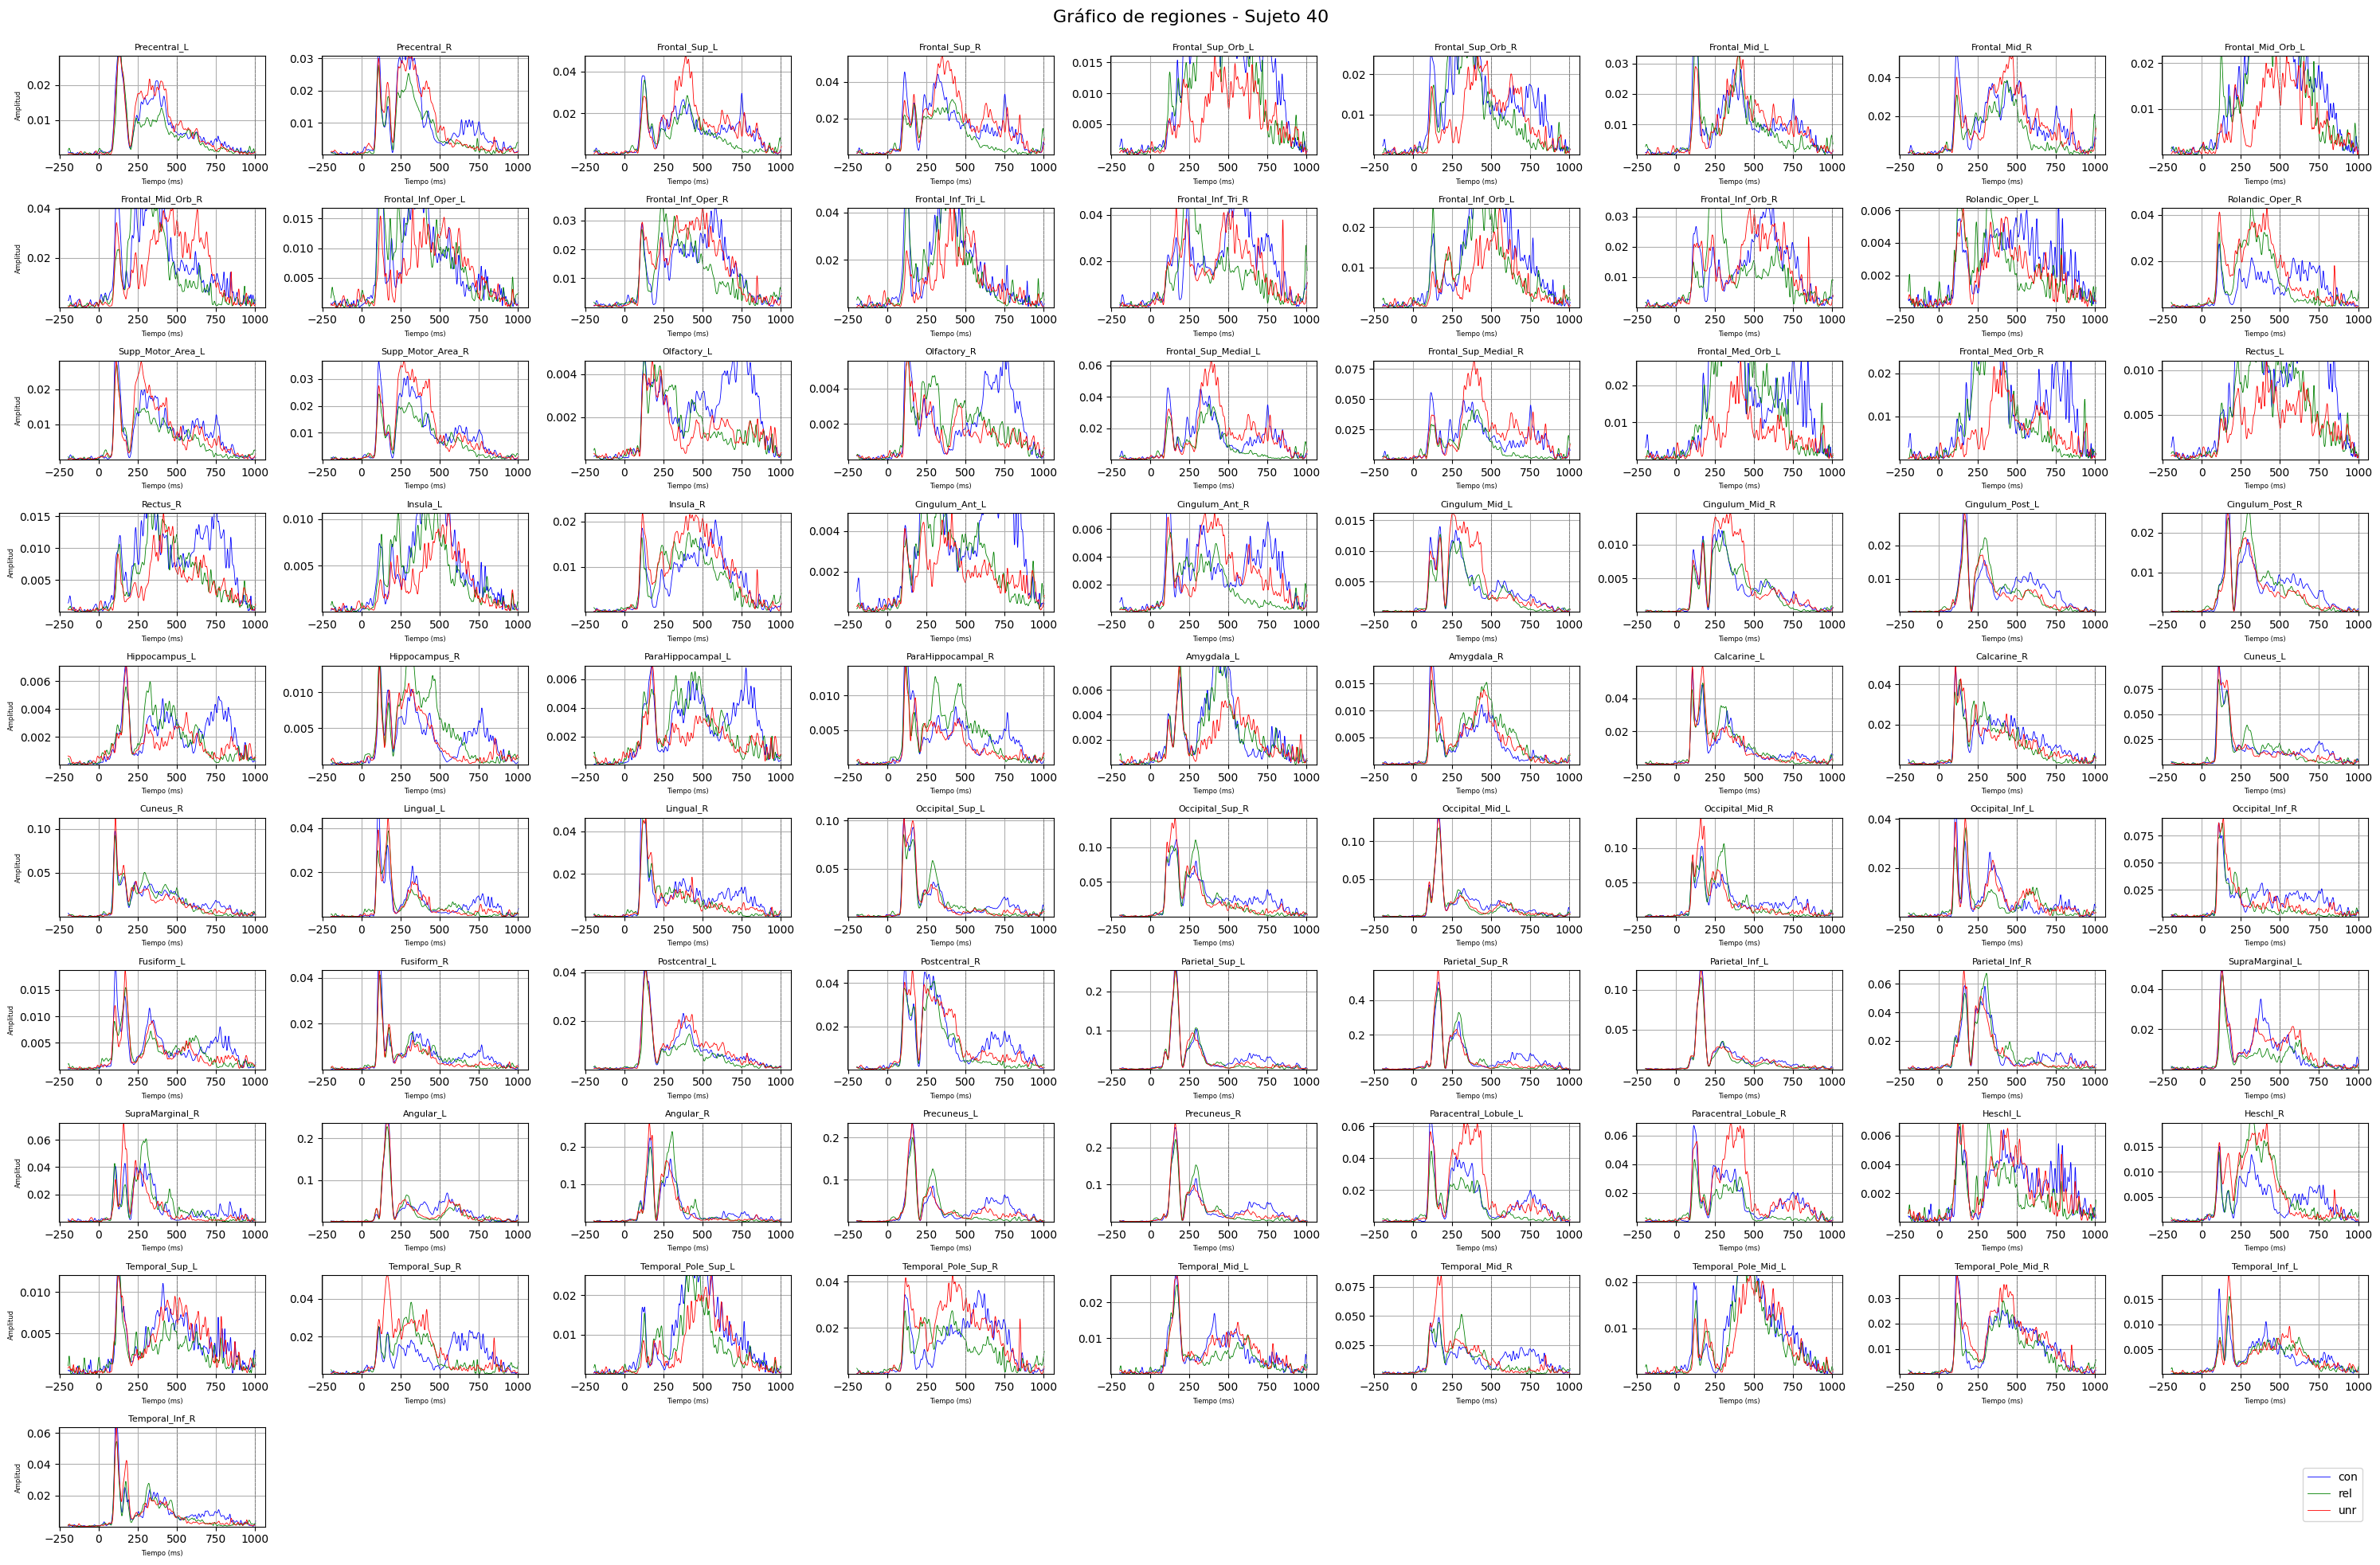

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Colores para cada condición
colors = {
    'con': 'b',   # Azul
    'rel': 'g',   # Verde
    'unr': 'r',   # Rojo
    'con_2': 'c', # Cian
    'rel_2': 'm', # Magenta
    'unr_2': 'y'  # Amarillo
}

# Función para graficar las regiones
def plot_regions(dataframes, regions, title, colors, sample_rate=1024, pre_stimulus=200, line_width=0.6):
    fig, axes = plt.subplots(nrows=10, ncols=9, figsize=(30, 20))
    axes = axes.flatten()  # Convertir los ejes en un array 1D
    time = (np.arange(0, dataframes[regions[0]].shape[0]) - pre_stimulus) / sample_rate * 1000  # Tiempo en ms

    for idx, region in enumerate(regions):
        if region not in dataframes:
            continue

        df = dataframes[region]
        for i, col in enumerate(df.columns[:82]):  # Limitar a las primeras 82 regiones
            ax = axes[i]
            ax.plot(time, df[col], color=colors[region], label=region, linewidth=line_width)
            ax.set_title(col, fontsize=8)
            ax.grid(True)

            # Etiquetas y líneas de referencia
            ax.set_xlabel('Tiempo (ms)', fontsize=6)
            if i % 9 == 0:  # Solo la primera columna tiene la etiqueta del eje Y
                ax.set_ylabel('Amplitud', fontsize=6)
            ax.axvline(x=500, color='gray', linestyle='--', linewidth=0.7)
            ax.axvline(x=1000, color='gray', linestyle='--', linewidth=0.7)
            ax.set_ylim(df[col].min(), df[col].max())

        # Dejar en blanco los gráficos sobrantes
        for j in range(len(df.columns), len(axes)):
            axes[j].axis('off')

    # Ajustar diseño
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title, fontsize=16)
    
    # Leyenda
    handles, labels = axes[0].get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower right', fontsize=10, bbox_to_anchor=(1, 0))
    plt.show()


# Datos de ejemplo para el sujeto 40
sujeto_40_data = {
    'con': Datos['con']['Sujeto_40'],  # No es necesario especificar la sesión, se asume que es el DataFrame completo
    'rel': Datos['rel']['Sujeto_40'],  # Se puede ajustar según las sesiones específicas si se desea
    'unr': Datos['unr']['Sujeto_40']
}

# Llamar a la función con los datos del sujeto 40
plot_regions(
    dataframes=sujeto_40_data,
    regions=['con', 'rel', 'unr'],
    title='Gráfico de regiones - Sujeto 40',
    colors=colors
)


In [ ]:
Datos

In [ ]:
import numpy as np
import pandas as pd

# Definir la función para calcular el promedio en la ventana
def calcular_promedio_en_ventana(df, latencia, ventana=10, freq_muestreo=1024):
    # Verificar si df es válido
    if df is None or not isinstance(df, pd.DataFrame):
        raise ValueError("El DataFrame proporcionado no es válido.")
    
    # Convertir latencia a índice de la muestra (latencia en ms * freq de muestreo)
    indice_muestra = int(latencia * freq_muestreo / 1000)
    
    # Asegurarse de que el índice no esté fuera de los límites del DataFrame
    start = max(indice_muestra - ventana, 0)
    end = min(indice_muestra + ventana + 1, len(df))
    
    # Calcular el promedio sobre la ventana
    ventana_datos = df.iloc[start:end]
    return ventana_datos.mean(axis=0)



# Picos encontrados
peaks = {
    'con': {
        'N1': {'Latency': 97.65625, 'Amplitude': -1.935},
        'P2': {'Latency': 164.0625, 'Amplitude': 3.726},
        'N400': {'Latency': 388.671875, 'Amplitude': -2.345}
    },
    'rel': {
        'N1': {'Latency': 95.703125, 'Amplitude': -1.883},
        'P2': {'Latency': 165.0390625, 'Amplitude': 3.825},
        'N400': {'Latency': 349.609375, 'Amplitude': -2.704}
    },
    'unr': {
        'N1': {'Latency': 94.7265625, 'Amplitude': -1.903},
        'P2': {'Latency': 163.0859375, 'Amplitude': 3.835},
        'N400': {'Latency': 336.9140625, 'Amplitude': -2.784}
    }
}

# Crear el diccionario de resultados
promedios = {}

for clave, sujetos in Datos.items():
    promedios[clave] = {}
    
    for sujeto, df in sujetos.items():
        # Verificar si df es None o no es un DataFrame
        if df is None or not isinstance(df, pd.DataFrame):
            print(f"DataFrame no válido para {sujeto} en la condición {clave}.")
            continue
        
        promedios[clave][sujeto] = {}
        
        for peak, valores in peaks[clave].items():
            latencia = valores['Latency']
            
            # Calcular el promedio usando la función
            promedios[clave][sujeto][peak] = calcular_promedio_en_ventana(df, latencia)
    
# Mostrar los resultados
print(promedios)


In [75]:
promedios['con'].keys()

dict_keys(['Sujeto_10', 'Sujeto_11', 'Sujeto_13', 'Sujeto_14', 'Sujeto_15', 'Sujeto_16', 'Sujeto_17', 'Sujeto_18', 'Sujeto_19', 'Sujeto_1', 'Sujeto_21', 'Sujeto_22', 'Sujeto_23', 'Sujeto_24', 'Sujeto_25', 'Sujeto_26', 'Sujeto_27', 'Sujeto_28', 'Sujeto_29', 'Sujeto_2', 'Sujeto_30', 'Sujeto_31', 'Sujeto_32', 'Sujeto_33', 'Sujeto_34', 'Sujeto_35', 'Sujeto_36', 'Sujeto_37', 'Sujeto_38', 'Sujeto_3', 'Sujeto_40', 'Sujeto_4', 'Sujeto_5', 'Sujeto_6', 'Sujeto_7', 'Sujeto_8', 'Sujeto_9'])

In [76]:
Datos['rel']['Sujeto_40']

,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,...,Temporal_Sup_L,Temporal_Sup_R,Temporal_Pole_Sup_L,Temporal_Pole_Sup_R,Temporal_Mid_L,Temporal_Mid_R,Temporal_Pole_Mid_L,Temporal_Pole_Mid_R,Temporal_Inf_L,Temporal_Inf_R
0,0.001207,0.000938,0.002033,0.001818,0.000896,0.000480,0.002783,0.001356,0.001411,0.000563,...,0.001069,0.002401,0.001690,0.002572,0.001381,0.001974,0.001623,0.001666,0.001104,0.001236
1,0.001336,0.000888,0.002113,0.001877,0.000976,0.000541,0.002965,0.001351,0.001543,0.000597,...,0.001225,0.002234,0.001851,0.002470,0.001538,0.001861,0.001775,0.001669,0.001196,0.001241
2,0.001470,0.000838,0.002176,0.001918,0.001034,0.000582,0.003135,0.001340,0.001643,0.000596,...,0.001421,0.002085,0.002021,0.002373,0.001724,0.001763,0.001911,0.001663,0.001271,0.001239
3,0.001602,0.000790,0.002218,0.001939,0.001065,0.000603,0.003281,0.001323,0.001702,0.000560,...,0.001644,0.001951,0.002186,0.002277,0.001924,0.001676,0.002016,0.001640,0.001319,0.001226
4,0.001719,0.000749,0.002243,0.001946,0.001070,0.000610,0.003395,0.001305,0.001717,0.000499,...,0.001870,0.001835,0.002328,0.002183,0.002118,0.001601,0.002077,0.001600,0.001334,0.001200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,0.000374,0.003901,0.006397,0.011554,0.000675,0.001657,0.005008,0.016844,0.001514,0.003325,...,0.001306,0.004149,0.002120,0.007901,0.001665,0.003666,0.001608,0.004675,0.001232,0.001834
1225,0.000350,0.003898,0.006039,0.010784,0.000695,0.001600,0.004551,0.015690,0.001490,0.003447,...,0.001549,0.004639,0.002057,0.008469,0.001842,0.003887,0.001475,0.004977,0.001324,0.001890
1226,0.000365,0.003891,0.005783,0.010135,0.000746,0.001555,0.004150,0.014687,0.001477,0.003510,...,0.001824,0.005174,0.001954,0.009038,0.002105,0.004172,0.001309,0.005280,0.001426,0.001968
1227,0.000402,0.003875,0.005646,0.009657,0.000809,0.001522,0.003834,0.013908,0.001442,0.003483,...,0.002110,0.005703,0.001826,0.009544,0.002429,0.004492,0.001134,0.005548,0.001543,0.002063


In [82]:
import numpy as np
import pandas as pd
from scipy import stats

# Definir las condiciones
condiciones = ['con', 'rel', 'unr']

# Inicializar un diccionario para los resultados de ANOVA
resultados_anova = {}

# Iterar sobre los picos (N1, P2, N400)
for pico in peaks['con'].keys():
    print(f"Analizando {pico}...")
    
    # Inicializar un diccionario para almacenar los valores por condición
    valores_por_condicion = {condicion: [] for condicion in condiciones}
    
    # Iterar sobre las condiciones y extraer los valores de cada región
    for condicion in condiciones:
        for sujeto, datos in promedios[condicion].items():
            if pico in datos:
                # Obtener los valores de la región para ese sujeto (como un pandas.Series)
                valores_por_condicion[condicion].append(datos[pico])
    
    # Asegurarse de que todas las listas de valores sean del mismo tamaño
    regiones = list(valores_por_condicion['con'][0].index)  # Suponiendo que todos los sujetos tienen las mismas regiones
    anova_resultados = {}
    
    # Realizar la prueba ANOVA para cada región
    for region in regiones:
        # Extraer los valores de esa región para cada condición
        valores_region = [np.array([datos[region] for datos in valores_por_condicion[condicion]]) for condicion in condiciones]
        
        # Realizar ANOVA
        f_stat, p_val = stats.f_oneway(*valores_region)
        anova_resultados[region] = p_val

    # Guardar los resultados de ANOVA para el pico actual
    resultados_anova[pico] = anova_resultados

# Mostrar los resultados de ANOVA
for pico, anova in resultados_anova.items():
    print(f"\nResultados ANOVA para {pico}:")
    for region, p_val in anova.items():
        print(f"  Región: {region}, p-valor: {p_val}")
        
        # Determinar si la diferencia es significativa
        if p_val < 0.05:
            print(f"  * Diferencia significativa en la región {region}")


Analizando N1...
Analizando P2...
Analizando N400...

Resultados ANOVA para N1:
  Región: Precentral_L, p-valor: 0.3339868236036969
  Región: Precentral_R, p-valor: 0.797423539947146
  Región: Frontal_Sup_L, p-valor: 0.2591007792981018
  Región: Frontal_Sup_R, p-valor: 0.5354976319745504
  Región: Frontal_Sup_Orb_L, p-valor: 0.6117814283326362
  Región: Frontal_Sup_Orb_R, p-valor: 0.5315250224764634
  Región: Frontal_Mid_L, p-valor: 0.24824788968688827
  Región: Frontal_Mid_R, p-valor: 0.414851251824795
  Región: Frontal_Mid_Orb_L, p-valor: 0.5351390013775742
  Región: Frontal_Mid_Orb_R, p-valor: 0.49911864134265516
  Región: Frontal_Inf_Oper_L, p-valor: 0.5333775056773047
  Región: Frontal_Inf_Oper_R, p-valor: 0.5952728243534244
  Región: Frontal_Inf_Tri_L, p-valor: 0.32216611184898697
  Región: Frontal_Inf_Tri_R, p-valor: 0.6532736655585859
  Región: Frontal_Inf_Orb_L, p-valor: 0.40168806050755235
  Región: Frontal_Inf_Orb_R, p-valor: 0.3127166878432675
  Región: Rolandic_Oper_L, p-v

# Ventana de interes

In [ ]:
import numpy as np
import pandas as pd

# Definir la función para calcular el promedio en la ventana
def calcular_promedio_en_ventana(df, latencia, ventana=10, freq_muestreo=1024):
    # Verificar si df es válido
    if df is None or not isinstance(df, pd.DataFrame):
        raise ValueError("El DataFrame proporcionado no es válido.")
    
    # Convertir latencia a índice de la muestra (latencia en ms * freq de muestreo)
    indice_muestra = int(latencia * freq_muestreo / 1000)
    
    # Asegurarse de que el índice no esté fuera de los límites del DataFrame
    start = max(indice_muestra - ventana, 0)
    end = min(indice_muestra + ventana + 1, len(df))
    
    # Calcular el promedio sobre la ventana
    ventana_datos = df.iloc[start:end]
    return ventana_datos.mean(axis=0)



# Picos encontrados
peaks = {
    'con': {
        'N1': {'Latency': 97.65625, 'Amplitude': -1.935},
        'P2': {'Latency': 164.0625, 'Amplitude': 3.726},
        'N400': {'Latency': 388.671875, 'Amplitude': -2.345},
        'interes': {'Latency' : 948.2421875, 'Amplitude' : 0.5413408279418945}
    },
    'rel': {
        'N1': {'Latency': 95.703125, 'Amplitude': -1.883},
        'P2': {'Latency': 165.0390625, 'Amplitude': 3.825},
        'N400': {'Latency': 349.609375, 'Amplitude': -2.704},
        'interes':{'Latency': 953.125, 'Amplitude' : 0.4169944226741791}
    },
    'unr': {
        'N1': {'Latency': 94.7265625, 'Amplitude': -1.903},
        'P2': {'Latency': 163.0859375, 'Amplitude': 3.835},
        'N400': {'Latency': 336.9140625, 'Amplitude': -2.784},
        'interes': {'Latency' : 963.8671875, 'Amplitude' : 0.4434204399585724}
    }
}

# Crear el diccionario de resultados
promedios = {}

for clave, sujetos in Datos.items():
    promedios[clave] = {}
    
    for sujeto, df in sujetos.items():
        # Verificar si df es None o no es un DataFrame
        if df is None or not isinstance(df, pd.DataFrame):
            print(f"DataFrame no válido para {sujeto} en la condición {clave}.")
            continue
        
        promedios[clave][sujeto] = {}
        
        for peak, valores in peaks[clave].items():
            latencia = valores['Latency']
            
            # Calcular el promedio usando la función
            promedios[clave][sujeto][peak] = calcular_promedio_en_ventana(df, latencia)
    
# Mostrar los resultados
print(promedios)


In [86]:
import numpy as np
import pandas as pd
from scipy import stats

# Definir las condiciones
condiciones = ['con', 'rel', 'unr',]

# Inicializar un diccionario para los resultados de ANOVA
resultados_anova = {}

# Iterar sobre los picos (N1, P2, N400)
for pico in peaks['con'].keys():
    print(f"Analizando {pico}...")
    
    # Inicializar un diccionario para almacenar los valores por condición
    valores_por_condicion = {condicion: [] for condicion in condiciones}
    
    # Iterar sobre las condiciones y extraer los valores de cada región
    for condicion in condiciones:
        for sujeto, datos in promedios[condicion].items():
            if pico in datos:
                # Obtener los valores de la región para ese sujeto (como un pandas.Series)
                valores_por_condicion[condicion].append(datos[pico])
    
    # Asegurarse de que todas las listas de valores sean del mismo tamaño
    regiones = list(valores_por_condicion['con'][0].index)  # Suponiendo que todos los sujetos tienen las mismas regiones
    anova_resultados = {}
    
    # Realizar la prueba ANOVA para cada región
    for region in regiones:
        # Extraer los valores de esa región para cada condición
        valores_region = [np.array([datos[region] for datos in valores_por_condicion[condicion]]) for condicion in condiciones]
        
        # Realizar ANOVA
        f_stat, p_val = stats.f_oneway(*valores_region)
        anova_resultados[region] = p_val

    # Guardar los resultados de ANOVA para el pico actual
    resultados_anova[pico] = anova_resultados

# Mostrar los resultados de ANOVA
for pico, anova in resultados_anova.items():
    print(f"\nResultados ANOVA para {pico}:")
    for region, p_val in anova.items():
        print(f"  Región: {region}, p-valor: {p_val}")
        
        # Determinar si la diferencia es significativa
        if p_val < 0.05:
            print(f"  * Diferencia significativa en la región {region}")


Analizando N1...
Analizando P2...
Analizando N400...
Analizando interes...

Resultados ANOVA para N1:
  Región: Precentral_L, p-valor: 0.3339868236036969
  Región: Precentral_R, p-valor: 0.797423539947146
  Región: Frontal_Sup_L, p-valor: 0.2591007792981018
  Región: Frontal_Sup_R, p-valor: 0.5354976319745504
  Región: Frontal_Sup_Orb_L, p-valor: 0.6117814283326362
  Región: Frontal_Sup_Orb_R, p-valor: 0.5315250224764634
  Región: Frontal_Mid_L, p-valor: 0.24824788968688827
  Región: Frontal_Mid_R, p-valor: 0.414851251824795
  Región: Frontal_Mid_Orb_L, p-valor: 0.5351390013775742
  Región: Frontal_Mid_Orb_R, p-valor: 0.49911864134265516
  Región: Frontal_Inf_Oper_L, p-valor: 0.5333775056773047
  Región: Frontal_Inf_Oper_R, p-valor: 0.5952728243534244
  Región: Frontal_Inf_Tri_L, p-valor: 0.32216611184898697
  Región: Frontal_Inf_Tri_R, p-valor: 0.6532736655585859
  Región: Frontal_Inf_Orb_L, p-valor: 0.40168806050755235
  Región: Frontal_Inf_Orb_R, p-valor: 0.3127166878432675
  Región